In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/NLP\ Project

Mounted at /content/gdrive
/content/gdrive/MyDrive/NLP Project


In [2]:
! pip install -qq transformers
! pip install -qq transformers-interpret

     |████████████████████████████████| 3.4 MB 4.2 MB/s 
     |████████████████████████████████| 596 kB 38.2 MB/s 
     |████████████████████████████████| 3.3 MB 32.9 MB/s 
     |████████████████████████████████| 895 kB 36.2 MB/s 
     |████████████████████████████████| 61 kB 436 kB/s 
     |████████████████████████████████| 1.4 MB 6.3 MB/s 


In [3]:
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tqdm import tqdm
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader

# Import Data

In [4]:
with open("HateXPlainData/trainHateXplain", "rb") as file:
  train_data = pickle.load(file)

with open("HateXPlainData/valHateXplain", "rb") as file:
  val_data = pickle.load(file)

with open("HateXPlainData/testHateXplain", "rb") as file:
  test_data = pickle.load(file)

# Data Pre-Processing

In [5]:
BERT_MODEL_NAME = "distilbert-base-uncased"
MAX_LEN = 100
BATCH_SIZE = 16

tokenizer = DistilBertTokenizer.from_pretrained(BERT_MODEL_NAME)
labels = {'offensive': 2, 'hatespeech': 1, 'normal': 0}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [6]:
class DataSet:
  def __init__(self, data, tokenizer, class_labels):
    
    self.text, self.labels = zip(*data)
    self.tokenizer = tokenizer
    self.classes = class_labels
      
  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):

    text_encoding = self.tokenizer.encode_plus(" ".join(self.text[idx]), 
                                               add_special_tokens=True,
                                               truncation=True,
                                               max_length=MAX_LEN, 
                                               return_token_type_ids=False, 
                                               padding='max_length', 
                                               return_attention_mask=True, 
                                               return_tensors='pt'
                                              )

    return {'text': " ".join(self.text[idx]),
            'input_ids': text_encoding['input_ids'].flatten(),
            'attention_mask': text_encoding['attention_mask'].flatten(),
            'label': torch.tensor(self.classes[self.labels[idx]])
            }

In [7]:
train = DataSet(train_data, tokenizer, labels)
val = DataSet(val_data, tokenizer, labels)
test = DataSet(test_data, tokenizer, labels)
train_dataloader = DataLoader(train, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test, batch_size=BATCH_SIZE)

# Tweet Classification Model w/ DistilBERT

In [8]:
class TweetClassifier(nn.Module):
  def __init__(self, num_classes):
    super(TweetClassifier, self).__init__()

    self.bert = DistilBertModel.from_pretrained(BERT_MODEL_NAME)
    self.drop_layer = nn.Dropout(p=0.3)
    self.out_layer = nn.Linear(self.bert.config.hidden_size, num_classes)
    self.out_act = nn.Softmax(dim=1)
    self.loss_fn = nn.CrossEntropyLoss()

  def forward(self, input, mask):

    bert_output = self.bert(input_ids=input, attention_mask=mask)
    p_out = bert_output[0][:, 0]
    drop_out = self.drop_layer(p_out)
    output = self.out_layer(drop_out)
    return self.out_act(output)

  def fit(self, train_dl, val_dl, epochs, optim):

    train_data = train_dl
    train_size = len(train_data.dataset.text)

    optimizer = optim

    for i in range(epochs):
      self.train()
      train_loss = 0
      train_acc = 0
      print(f'Epochs: {i + 1}')

      for data in tqdm(train_data):
        inputs = data['input_ids'].to(device)
        masks = data['attention_mask'].to(device)
        targets = data['label'].to(device)

        outputs = self.forward(inputs, masks) 

        batch_loss = self.loss_fn(outputs, targets)
        train_loss += batch_loss.item()

        acc = (outputs.argmax(dim=1) == targets).sum().item()
        train_acc += acc

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

      print(f'Train Loss: {train_loss / train_size: .3f} | Train Accuracy: {train_acc / train_size: .3f}')

      self.evaluate(val_dl, calc_loss=True)

  def evaluate(self, eval_dl, calc_loss=False):
    self.eval()

    eval_data = eval_dl
    eval_size = len(eval_data.dataset.text)
    eval_acc = 0
    if calc_loss:
      eval_loss = 0

    predictions = torch.tensor([])

    with torch.no_grad():
      
      for data in tqdm(eval_data):
        inputs = data['input_ids'].to(device)
        masks = data['attention_mask'].to(device)
        targets = data['label'].to(device)

        outputs = self.forward(inputs, masks)

        if calc_loss:
          batch_loss = self.loss_fn(outputs, targets)
          eval_loss += batch_loss.item()

        batch_pred = outputs.argmax(dim=1)
        predictions = torch.cat((predictions, batch_pred.to(device="cpu")), 0)
        acc = (batch_pred == targets).sum().item()
        eval_acc += acc

    if calc_loss:
      print(f'Eval Loss: {eval_loss / eval_size: .3f} | Eval Accuracy: {eval_acc / eval_size: .3f}')
    else:
      print(f'Eval Accuracy: {eval_acc / eval_size: .3f}')

    return predictions


In [9]:
tmodel = TweetClassifier(len(labels)).to(device)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
optim = Adam(tmodel.parameters(), lr=5e-5, weight_decay=0.01)

tmodel.fit(train_dataloader, val_dataloader, 8, optim)

Epochs: 1


100%|██████████| 962/962 [04:30<00:00,  3.56it/s]


Train Loss:  0.058 | Train Accuracy:  0.612


100%|██████████| 121/121 [00:13<00:00,  8.96it/s]


Eval Loss:  0.056 | Eval Accuracy:  0.648
Epochs: 2


100%|██████████| 962/962 [04:29<00:00,  3.57it/s]


Train Loss:  0.056 | Train Accuracy:  0.647


100%|██████████| 121/121 [00:13<00:00,  8.90it/s]


Eval Loss:  0.056 | Eval Accuracy:  0.659
Epochs: 3


100%|██████████| 962/962 [04:29<00:00,  3.57it/s]


Train Loss:  0.055 | Train Accuracy:  0.671


100%|██████████| 121/121 [00:13<00:00,  8.91it/s]


Eval Loss:  0.056 | Eval Accuracy:  0.640
Epochs: 4


100%|██████████| 962/962 [04:29<00:00,  3.57it/s]


Train Loss:  0.053 | Train Accuracy:  0.693


100%|██████████| 121/121 [00:13<00:00,  8.84it/s]


Eval Loss:  0.056 | Eval Accuracy:  0.642
Epochs: 5


100%|██████████| 962/962 [04:29<00:00,  3.57it/s]


Train Loss:  0.052 | Train Accuracy:  0.724


100%|██████████| 121/121 [00:13<00:00,  8.98it/s]


Eval Loss:  0.056 | Eval Accuracy:  0.654
Epochs: 6


100%|██████████| 962/962 [04:29<00:00,  3.58it/s]


Train Loss:  0.050 | Train Accuracy:  0.758


100%|██████████| 121/121 [00:13<00:00,  8.88it/s]


Eval Loss:  0.056 | Eval Accuracy:  0.652
Epochs: 7


100%|██████████| 962/962 [04:29<00:00,  3.57it/s]


Train Loss:  0.048 | Train Accuracy:  0.782


100%|██████████| 121/121 [00:13<00:00,  8.95it/s]


Eval Loss:  0.056 | Eval Accuracy:  0.651
Epochs: 8


100%|██████████| 962/962 [04:29<00:00,  3.57it/s]


Train Loss:  0.047 | Train Accuracy:  0.805


100%|██████████| 121/121 [00:13<00:00,  8.93it/s]

Eval Loss:  0.057 | Eval Accuracy:  0.625


# Evaluating the Model

In [11]:
y_train_true = np.array([labels[label] for label in train.labels])
y_val_true = np.array([labels[label] for label in val.labels])
y_test_true = np.array([labels[label] for label in test.labels])
y_train_pred = tmodel.evaluate(train_dataloader)
y_val_pred = tmodel.evaluate(val_dataloader)
y_test_pred = tmodel.evaluate(test_dataloader)

100%|██████████| 962/962 [01:57<00:00,  8.17it/s]


Eval Accuracy:  0.836


100%|██████████| 121/121 [00:13<00:00,  8.98it/s]


Eval Accuracy:  0.625


100%|██████████| 121/121 [00:13<00:00,  8.98it/s]

Eval Accuracy:  0.624


Train Data Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      6251
           1       0.87      0.86      0.87      4748
           2       0.77      0.77      0.77      4384

    accuracy                           0.84     15383
   macro avg       0.83      0.83      0.83     15383
weighted avg       0.84      0.84      0.84     15383



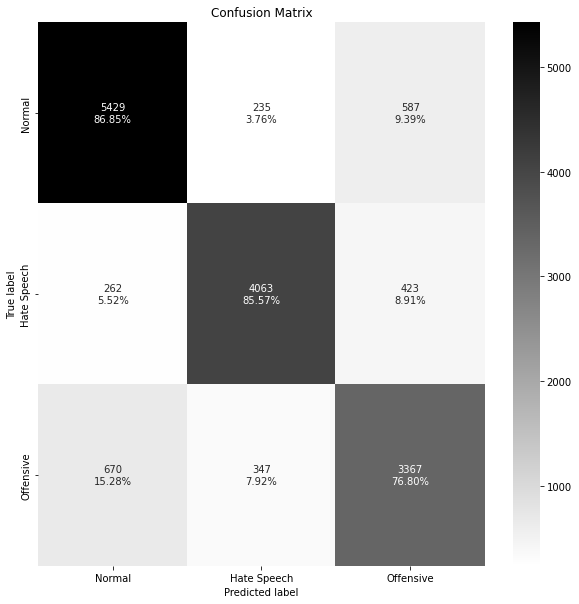

In [15]:
print("Train Data Accuracy: {0:0.2f}".format(accuracy_score(y_train_true, y_train_pred)))
    
print(classification_report(y_train_true, y_train_pred))
cf_matrix = confusion_matrix(y_train_true, y_train_pred)

label_counts = ["{}".format(value) for value in cf_matrix.flatten()]
label_percents = ["{0:.2%}".format(value / np.sum(row)) for row in cf_matrix for value in row]

box_labels = [f"{v1}\n{v2}\n".strip() for v1, v2 in zip(label_counts,label_percents)]
box_labels = np.asarray(box_labels).reshape(cf_matrix.shape[0], cf_matrix.shape[1])

plt.figure(figsize=(10,10))
sns.heatmap(cf_matrix, xticklabels=["Normal", "Hate Speech", "Offensive"], yticklabels=["Normal", "Hate Speech", "Offensive"], annot=box_labels, cmap='binary', fmt='')
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Validation Data Accuracy: 0.63
              precision    recall  f1-score   support

           0       0.67      0.66      0.66       781
           1       0.76      0.64      0.69       593
           2       0.47      0.56      0.51       548

    accuracy                           0.63      1922
   macro avg       0.63      0.62      0.62      1922
weighted avg       0.64      0.63      0.63      1922



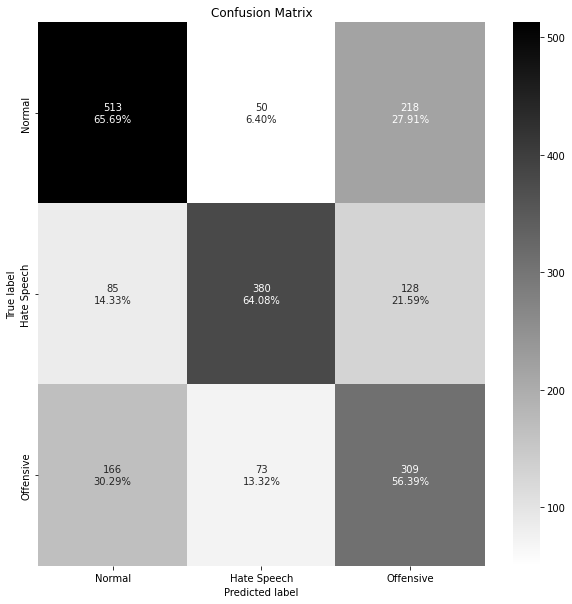

In [16]:
print("Validation Data Accuracy: {0:0.2f}".format(accuracy_score(y_val_true, y_val_pred)))
    
print(classification_report(y_val_true, y_val_pred))
cf_matrix = confusion_matrix(y_val_true, y_val_pred)

label_counts = ["{}".format(value) for value in cf_matrix.flatten()]
label_percents = ["{0:.2%}".format(value / np.sum(row)) for row in cf_matrix for value in row]

box_labels = [f"{v1}\n{v2}\n".strip() for v1, v2 in zip(label_counts,label_percents)]
box_labels = np.asarray(box_labels).reshape(cf_matrix.shape[0], cf_matrix.shape[1])

plt.figure(figsize=(10,10))
sns.heatmap(cf_matrix, xticklabels=["Normal", "Hate Speech", "Offensive"], yticklabels=["Normal", "Hate Speech", "Offensive"], annot=box_labels, cmap='binary', fmt='')
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Test Data Accuracy: 0.62
              precision    recall  f1-score   support

           0       0.68      0.65      0.67       782
           1       0.75      0.67      0.71       594
           2       0.45      0.53      0.49       548

    accuracy                           0.62      1924
   macro avg       0.63      0.62      0.62      1924
weighted avg       0.64      0.62      0.63      1924



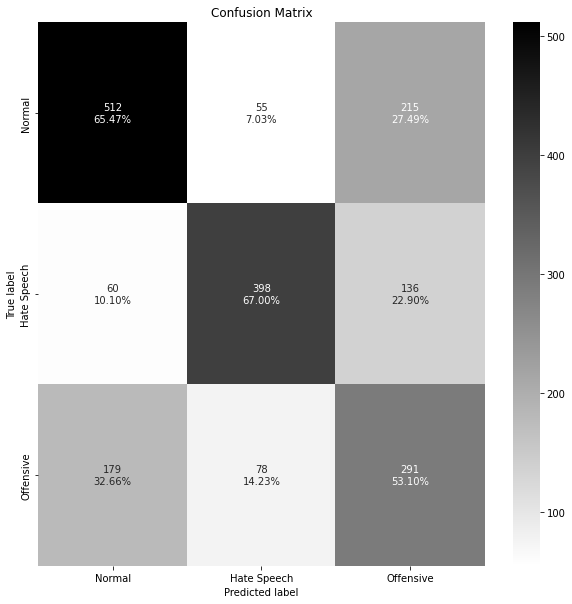

In [17]:
print("Test Data Accuracy: {0:0.2f}".format(accuracy_score(y_test_true, y_test_pred)))
    
print(classification_report(y_test_true, y_test_pred))
cf_matrix = confusion_matrix(y_test_true, y_test_pred)

label_counts = ["{}".format(value) for value in cf_matrix.flatten()]
label_percents = ["{0:.2%}".format(value / np.sum(row)) for row in cf_matrix for value in row]

box_labels = [f"{v1}\n{v2}\n".strip() for v1, v2 in zip(label_counts,label_percents)]
box_labels = np.asarray(box_labels).reshape(cf_matrix.shape[0], cf_matrix.shape[1])

plt.figure(figsize=(10,10))
sns.heatmap(cf_matrix, xticklabels=["Normal", "Hate Speech", "Offensive"], yticklabels=["Normal", "Hate Speech", "Offensive"], annot=box_labels, cmap='binary', fmt='')
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# New Section

# Using HuggingFace

In [ ]:
! pip install -qq datasets

     |████████████████████████████████| 306 kB 5.8 MB/s 
     |████████████████████████████████| 132 kB 42.6 MB/s 
     |████████████████████████████████| 243 kB 46.3 MB/s 
     |████████████████████████████████| 1.1 MB 42.4 MB/s 
     |████████████████████████████████| 192 kB 45.0 MB/s 
     |████████████████████████████████| 271 kB 40.2 MB/s 
     |████████████████████████████████| 160 kB 48.2 MB/s 


In [ ]:
from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification, 
                          Trainer, 
                          TrainingArguments)
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset, Dataset
import torch

dataset = load_dataset("hatexplain")
train_ds = dataset['train']
test_ds = dataset['test']
val_ds = dataset['validation']

label_extractor = lambda x: max(set(x['label']), key = x['label'].count)
train = {}
train['tokens'] = [' '.join(s) for s in train_ds['post_tokens']]
train['label'] = list(map(label_extractor, train_ds['annotators']))
train_ds = Dataset.from_dict(train)
val = {}
val['tokens'] = [' '.join(s) for s in val_ds['post_tokens']]
val['label'] = list(map(label_extractor, val_ds['annotators']))
val_ds = Dataset.from_dict(val)
test = {}
test['tokens'] = [' '.join(s) for s in test_ds['post_tokens']]
test['label'] = list(map(label_extractor, test_ds['annotators']))
test_ds = Dataset.from_dict(test)


tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenize_func = lambda sentences: tokenizer(sentences['tokens'], \
                                            padding="max_length", \
                                            truncation=True)

tok_train_ds = train_ds.map(tokenize_func, batched=True)
tok_test_ds = test_ds.map(tokenize_func, batched=True)
tok_val_ds = val_ds.map(tokenize_func, batched=True)

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
training_args = TrainingArguments(
    output_dir='./',          
    num_train_epochs=8,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./',            
    logging_steps=10
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

Downloading:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/2.03M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/145k [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset hatexplain downloaded and prepared to /root/.cache/huggingface/datasets/hatexplain/plain_text/1.0.0/df474d8d8667d89ef30649bf66e9c856ad8305bef4bc147e8e31cbdf1b8e0249. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

In [ ]:
trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=tok_train_ds,
    eval_dataset=tok_val_ds,
    compute_metrics=compute_metrics,
)

trainer.train()

trainer.evaluate()

***** Running training *****
  Num examples = 15383
  Num Epochs = 8
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 7696


Step,Training Loss
10,1.118000
20,1.097500
30,1.098400
40,1.089400
50,1.096900
60,1.072400
70,1.081000
80,1.061700
90,1.040500
100,1.070800


Saving model checkpoint to ./checkpoint-500
Configuration saved in ./checkpoint-500/config.json
Model weights saved in ./checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./checkpoint-1000
Configuration saved in ./checkpoint-1000/config.json
Model weights saved in ./checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./checkpoint-1500
Configuration saved in ./checkpoint-1500/config.json
Model weights saved in ./checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./checkpoint-2000
Configuration saved in ./checkpoint-2000/config.json
Model weights saved in ./checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./checkpoint-2500
Configuration saved in ./checkpoint-2500/config.json
Model weights saved in ./checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./checkpoint-3000
Configuration saved in ./checkpoint-3000/config.json
Model weights saved in ./checkpoint-3000/pytorch_model.bin
Saving model checkpoint to ./checkpoint-3500
Configuration sa

{'epoch': 8.0,
 'eval_accuracy': 0.6612903225806451,
 'eval_f1': 0.6541340348665475,
 'eval_loss': 2.433418035507202,
 'eval_precision': 0.6537612255542213,
 'eval_recall': 0.6554382375054429,
 'eval_runtime': 63.8142,
 'eval_samples_per_second': 30.119,
 'eval_steps_per_second': 1.896}

In [ ]:
test_output = trainer.predict(test_dataset=tok_test_ds)
print(test_output.metrics)

***** Running Prediction *****
  Num examples = 1924
  Batch size = 16


{'test_loss': 2.424736499786377, 'test_accuracy': 0.6548856548856549, 'test_f1': 0.6453399806549734, 'test_precision': 0.64513235694743, 'test_recall': 0.6466744438303421, 'test_runtime': 64.0211, 'test_samples_per_second': 30.053, 'test_steps_per_second': 1.89}
